In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from vit_keras import vit
from tensorflow.keras.applications import EfficientNetB0
import os
import numpy as np

In [12]:
class ChestXRayClassifier:
    def __init__(self, data_directory, csv_file, target_size=(224, 224), batch_size=32):
        self.data_directory = data_directory
        self.csv_file = csv_file
        self.target_size = target_size
        self.batch_size = batch_size
        self.model = None  # Model is not initialized here anymore
        self.datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    def build_vit_model(self):
        vit_model = vit.vit_b16(
            image_size=self.target_size,
            activation='softmax',
            pretrained=True,
            include_top=False,
            pretrained_top=False,
            classes=3
        )
        model = Sequential([
            vit_model,
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
        return model

    def build_efficientnet_model(self):
        base_model = EfficientNetB0(include_top=False, input_shape=(*self.target_size, 3), weights="imagenet")
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
        return model

    def compile_model(self, model_choice):
        if model_choice == 'vit':
            self.model = self.build_vit_model()
        elif model_choice == 'efficientnet':
            self.model = self.build_efficientnet_model()
        else:
            raise ValueError("Invalid model choice. Please choose 'vit' or 'efficientnet'.")
        
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def train_model(self):
        train_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='training',
            target_size=self.target_size
        )
        validation_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='validation',
            target_size=self.target_size
        )
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=1
        )
        history = self.model.fit(
            train_generator,
            epochs=30,
            validation_data=validation_generator,
            callbacks=[early_stopping]
        )
        return history

    def plot_history(self, history, model_name):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{model_name} Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def evaluate_model(self, test_directory, model_name="Model"):
        datagen = ImageDataGenerator()
        test_generator = datagen.flow_from_directory(
            test_directory,
            target_size=self.target_size, 
            batch_size=self.batch_size,
            shuffle=False
        )
        
        predictions = self.model.predict(test_generator)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = test_generator.classes
        cm = confusion_matrix(true_labels, predicted_labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=test_generator.class_indices.keys(),
                    yticklabels=test_generator.class_indices.keys())
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        print(f"Classification Report for {model_name}:\n",
              classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

In [3]:
# Script to use the classifier
data_directory = 'train'  # Path to your training data
csv_file = 'train.csv'    # Path to your CSV file
test_directory = 'test'   # Path to your test data

In [4]:
# Initialize the classifier
classifier = ChestXRayClassifier(data_directory, csv_file)


In [5]:
# Choose the model you want to use: 'vit' or 'efficientnet'
model_choice = 'vit'  # or 'efficientnet'
model_name = "Vision Transformer" if model_choice == 'vit' else "EfficientNetB0"


2024-03-29 10:37:14.501407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.
Epoch 1/30
30/30 [==============================] - 1002s 33s/step - loss: 1.4736 - accuracy: 0.3570 - val_loss: 0.9866 - val_accuracy: 0.4832
Epoch 2/30
30/30 [==============================] - 1157s 39s/step - loss: 1.0400 - accuracy: 0.4207 - val_loss: 0.9761 - val_accuracy: 0.5168
Epoch 3/30
30/30 [==============================] - 990s 33s/step - loss: 0.9775 - accuracy: 0.4906 - val_loss: 1.1015 - val_accuracy: 0.3571
Epoch 4/30
30/30 [==============================] - 1075s 36s/step - loss: 0.9804 - accuracy: 0.4812 - val_loss: 0.8855 - val_accuracy: 0.5294
Epoch 5/30
30/30 [==============================] - 1101s 37s/step - loss: 0.9239 - accuracy: 0.5344 - val_loss: 0.9323 - val_accuracy: 0.4832
Epoch 6/30
30/30 [==============================] - 994s 33s/step - loss: 0.9026 - accuracy: 0.5167 - val_loss: 0.8768 - val_accuracy: 0.5210
Epoch 7/30
30/30 [==============================] - 938s 31s/s

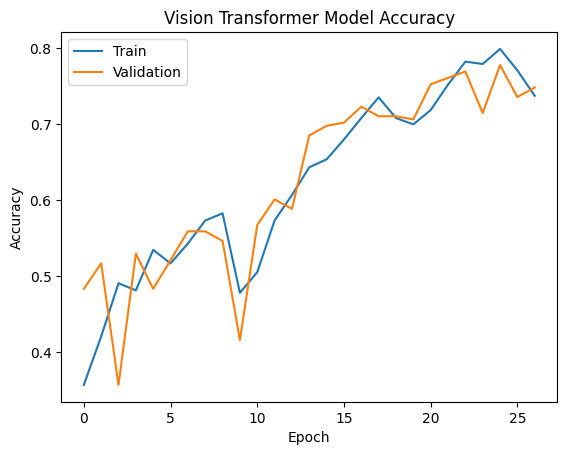

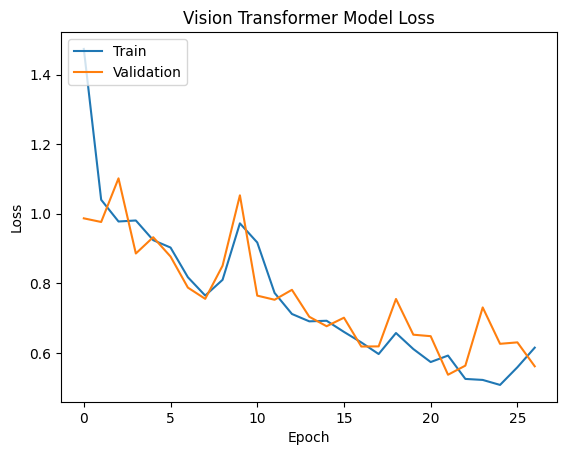

Found 1288 images belonging to 3 classes.


NameError: name 'np' is not defined

In [6]:
# Compile, train, and evaluate the model
classifier.compile_model(model_choice)
history = classifier.train_model()
classifier.plot_history(history, model_name)
classifier.evaluate_model(test_directory, model_name)

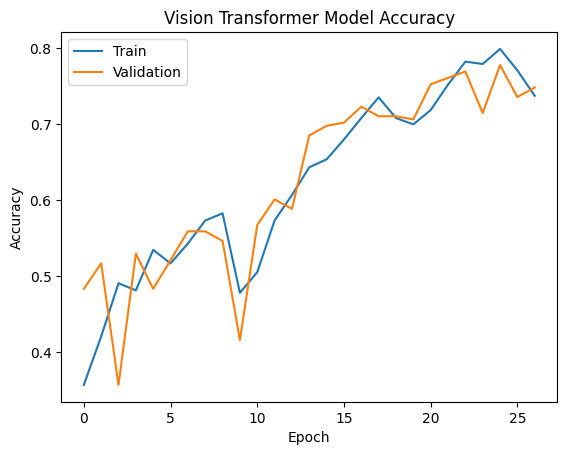

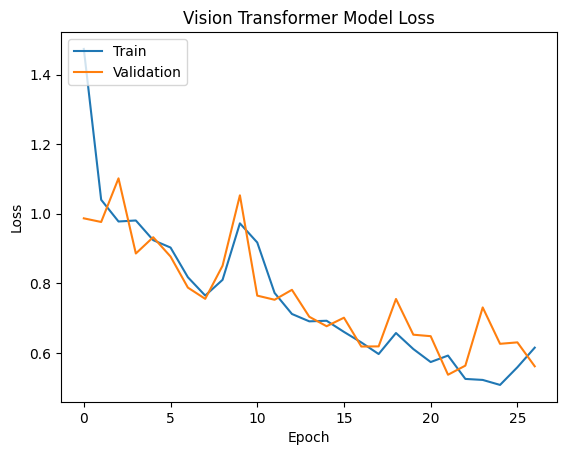

Found 1288 images belonging to 3 classes.


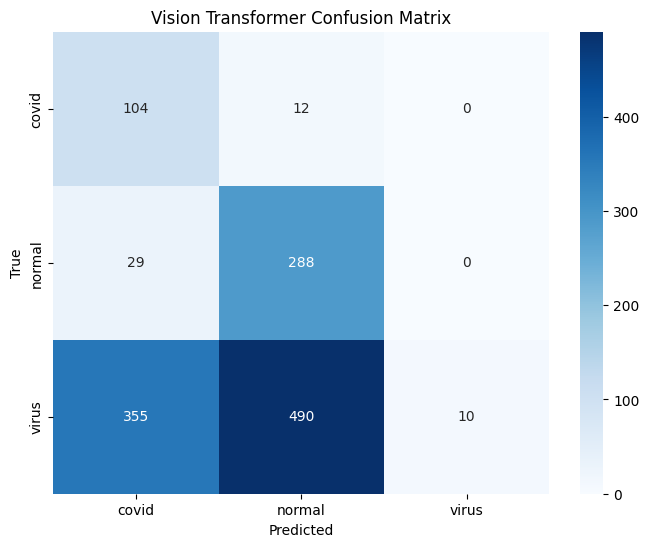

Classification Report for Vision Transformer:
               precision    recall  f1-score   support

       covid       0.21      0.90      0.34       116
      normal       0.36      0.91      0.52       317
       virus       1.00      0.01      0.02       855

    accuracy                           0.31      1288
   macro avg       0.53      0.61      0.30      1288
weighted avg       0.77      0.31      0.17      1288



In [8]:
classifier.plot_history(history, model_name)
classifier.evaluate_model(test_directory, model_name)